In [48]:
# Example: Custom Layout Pass with NetworkX for VQE or GHZ optimization

from qiskit import QuantumCircuit, transpile
from qiskit.transpiler import CouplingMap, Layout, PassManager, TransformationPass
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.transpiler.passes import SetLayout,VF2Layout
import qiskit_ibm_runtime.fake_provider as fk  # Example IBM device
import networkx as nx
from qiskit.circuit.library import RealAmplitudes
from qiskit.visualization import plot_circuit_layout, plot_coupling_map
import networkx as nx
from qiskit.transpiler import Layout, CouplingMap

basic TwoLocal circuit with circular entanglement, and real amplitude.
Usefule for:
 1) QOAO: Simulating periodic Ising chains 
 2) VQE
 etc..
            

/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/2492680141.py:5: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  qc= RealAmplitudes(num_qubits=n,reps=1\


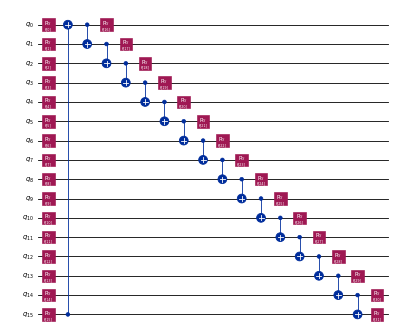

In [78]:
n=16
backend = fk.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

qc= RealAmplitudes(num_qubits=n,reps=1\
                   ,entanglement='circular',flatten=True)

qc.draw('mpl',scale=0.3)

While VF2++ does a good layout mapping from logical qubits to physical qubits. Methods like 'sabre' and 'trivial' can be significantly improved.

Besides, VF2++ is extremely costly for large circuits

/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/82342171.py:1: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


circuit depth 37
CNOT count 28


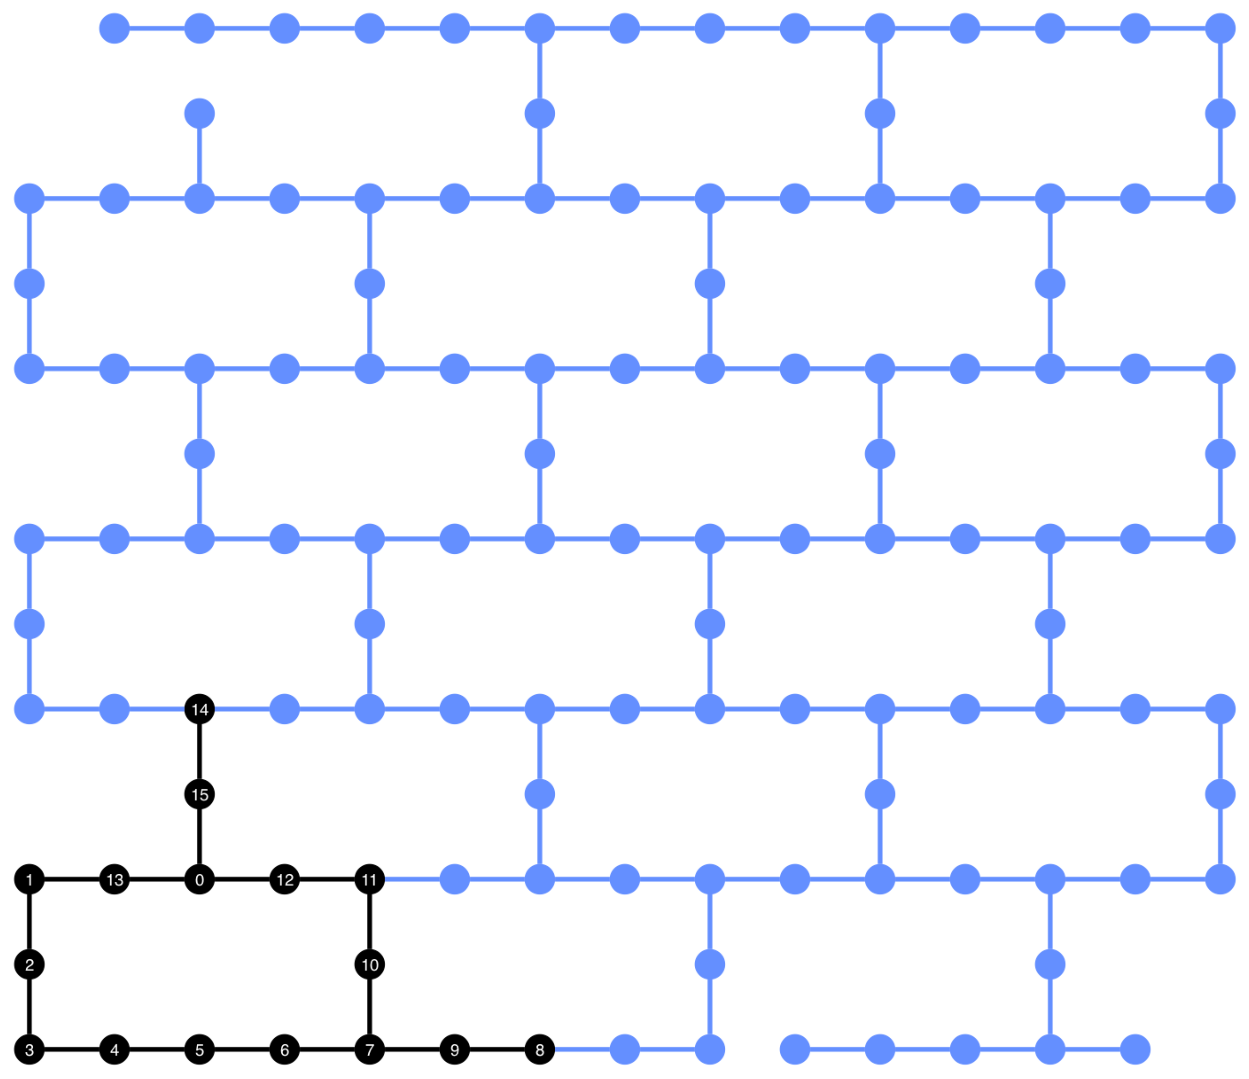

In [73]:
pass_manager = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        layout_method='sabre',
        coupling_map=cm)
    
transpiled_circ = pass_manager.run(qc)

print("circuit depth",transpiled_circ.depth())
print("CNOT count",transpiled_circ.count_ops().get("cx", 0))
plot_circuit_layout(transpiled_circ, backend)


Here we try to find the best cyclic subgraph that can represent our circuit

In [67]:


def find_best_cycle(coupling_map: CouplingMap, n: int):
    """
    Find exact cycle of length n, else nearest larger cycle.
    """
    G = nx.Graph()
    G.add_edges_from(coupling_map.get_edges())
    cycles = list(nx.cycle_basis(G))

    exact = [c for c in cycles if len(c) == n]
    larger = [c for c in cycles if len(c) > n]

    if exact:
        return exact[0]
    if larger:
        # Pick smallest larger cycle
        return min(larger, key=len)
    return None

def adaptive_ring_layout(logical_qubits: int, coupling_map: CouplingMap):
    """
    Adaptive layout for ring circuits with ancilla if needed.
    """
    cycle = find_best_cycle(coupling_map, logical_qubits)
    if cycle is None:
        raise ValueError("No valid cycles found in hardware coupling map.")

    required_qubits = len(cycle)
    ancilla = required_qubits - logical_qubits

    #layout_dict = {i: cycle[i] for i in range(required_qubits)}
    #layout = Layout(layout_dict)

    return required_qubits, ancilla#, layout



For each hardware backen, exact cyclic sub-graphs can be made only for certain qubit numbers.

However, one can add ancillas qubits till we reach such a number. We see that such a mapping almost always outperforms 'trivial' and 'sabre' methods

In [75]:
#n=14
backend = fk.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

# Determine layout and qubits
required_qubits, ancilla_count = adaptive_ring_layout(n, cm)
print(f"Logical qubits: {n}, Total needed: {required_qubits}, Ancilla: {ancilla_count}")

qc_cyclic= RealAmplitudes(num_qubits=required_qubits,reps=1\
                   ,entanglement='circular',flatten=True)

#obtain cycle-graph with circuit+ancilla qubits
cycle = find_best_cycle(cm, required_qubits)

layout_dict = {qc_cyclic.qubits[i]: cycle[i] for i in range(required_qubits)}
layout_cyclic = Layout(layout_dict)



Logical qubits: 16, Total needed: 20, Ancilla: 4


/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/3330713665.py:9: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  qc_cyclic= RealAmplitudes(num_qubits=required_qubits,reps=1\


/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/3515913798.py:1: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


depth 28
CNOT count 20


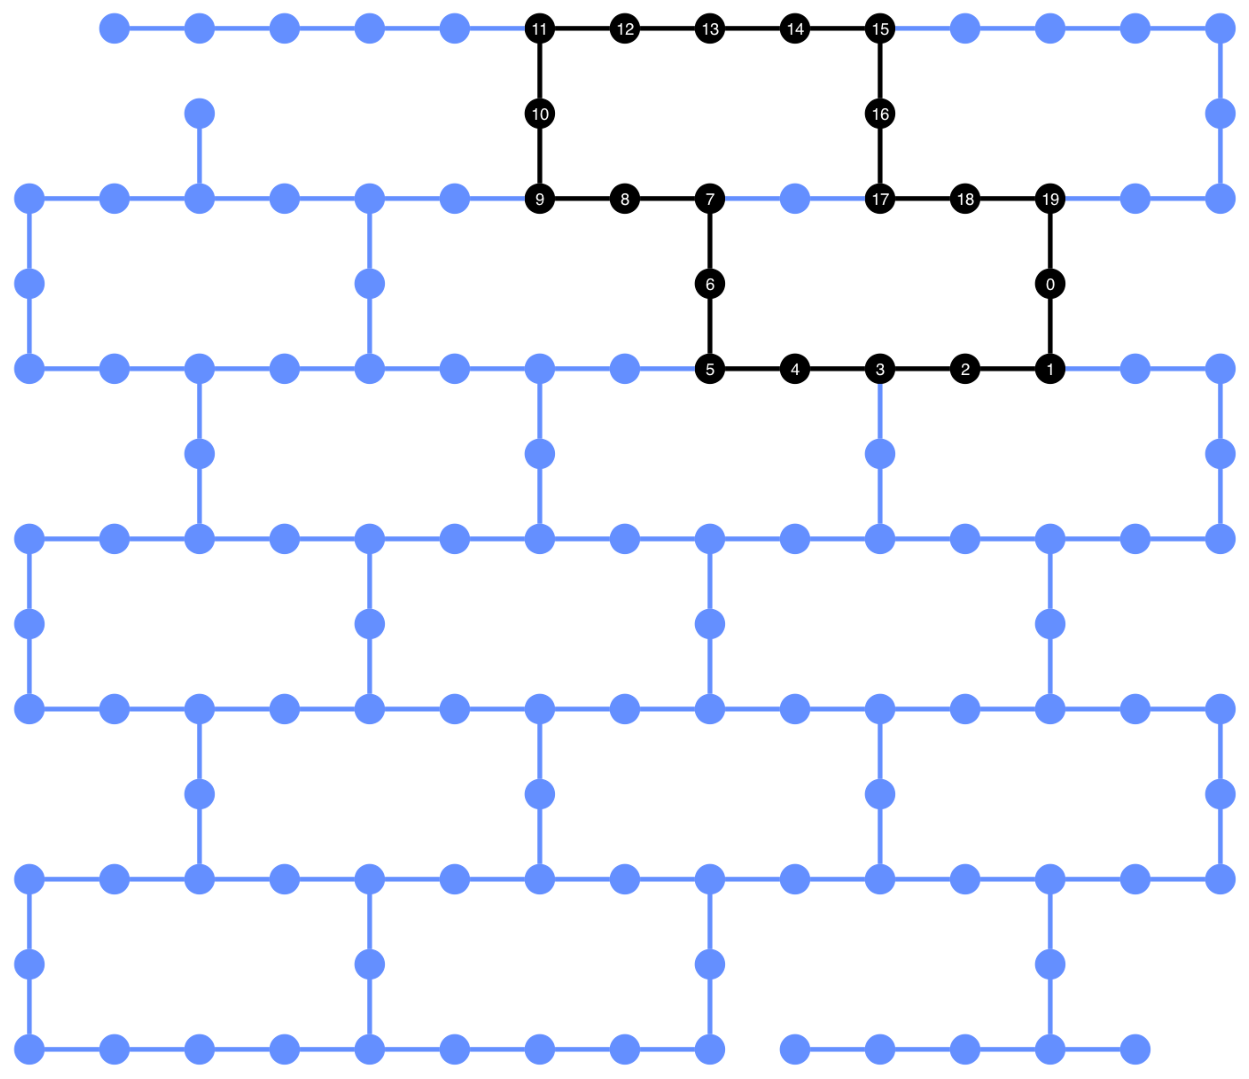

In [76]:
pass_manager = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_cyclic,
        coupling_map=cm)
    
transpiled_circ = pass_manager.run(qc_cyclic)

print("depth",transpiled_circ.depth())
print("CNOT count",transpiled_circ.count_ops().get("cx", 0))
plot_circuit_layout(transpiled_circ, backend)

Incase of simulating periodic Hamiltonians (using QAOA for example), adding further ancilla qubits will change the cost Hamiltonian.

However, one can still find the smallest cyclic sub-graph that is larger than the given circuit and then choose to map it partially.

Such an approach will minimize the distance between the first and last qubits, reducing the SWAP gate overhead

Logical qubits: 16, minimum largest needed for a circle:       20, Ancilla: 4
depth 42
CNOT count 40


/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/4011937839.py:10: DeprecationWarning: The class ``qiskit.circuit.library.n_local.real_amplitudes.RealAmplitudes`` is deprecated as of Qiskit 2.1. It will be removed in Qiskit 3.0. Use the function qiskit.circuit.library.real_amplitudes instead.
  qc_approx= RealAmplitudes(num_qubits=n,reps=1\
/var/folders/_9/dhlh8y415jx54r4xwjd06yp40000gq/T/ipykernel_13467/4011937839.py:18: UserWarning: Providing `coupling_map` and/or `basis_gates` along with `backend` is not recommended, as this will invalidate the backend's gate durations and error rates.
  pass_manager = generate_preset_pass_manager(


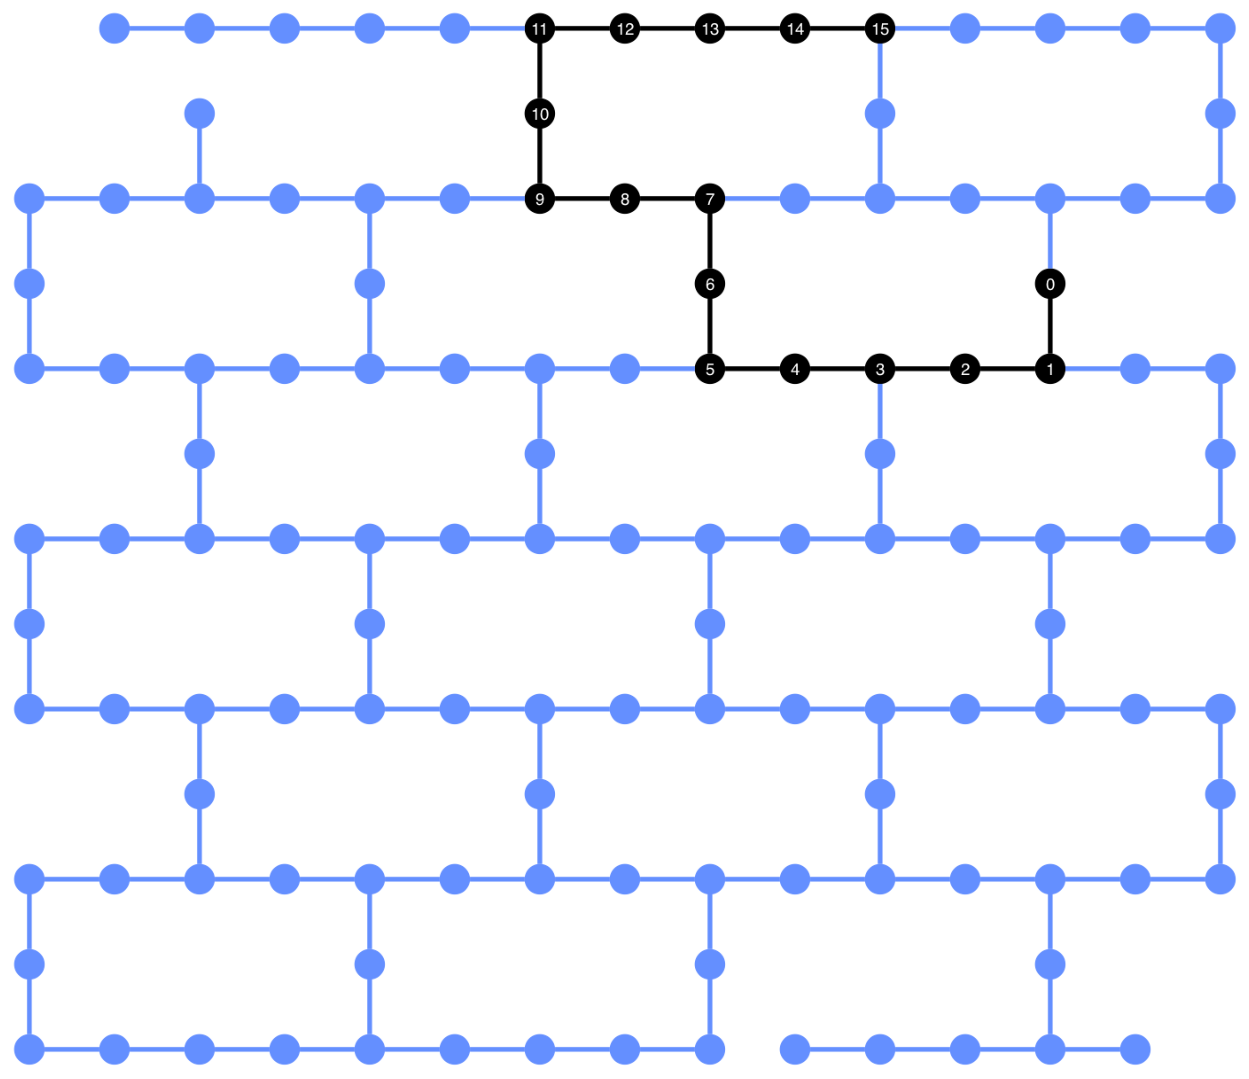

In [79]:
n=16
backend = fk.FakeWashingtonV2()
cm = CouplingMap(backend.configuration().coupling_map)

# Determine layout and qubits
required_qubits, ancilla_count = adaptive_ring_layout(n, cm)
print(f"Logical qubits: {n}, minimum largest needed for a circle:\
       {required_qubits}, Ancilla: {ancilla_count}")

qc_approx= RealAmplitudes(num_qubits=n,reps=1\
                   ,entanglement='circular',flatten=True)

#obtain cycle-graph with circuit+ancilla qubits
cycle = find_best_cycle(cm, required_qubits)

layout_dict = {qc.qubits[i]: cycle[i] for i in range(n)}
layout_approx = Layout(layout_dict)
pass_manager = generate_preset_pass_manager(
        optimization_level=2,
        backend=backend,
        initial_layout=layout_approx,
        coupling_map=cm)
    
transpiled_circ = pass_manager.run(qc_approx)

print("depth",transpiled_circ.depth())
print("CNOT count",transpiled_circ.count_ops().get("cx", 0))
plot_circuit_layout(transpiled_circ, backend)
